In [1]:
# work in progress

In [2]:
# Bayesian updating of:
#  - belief about the heat pain threshold
#  - to decide on the temperature for the next trial.
# 
# -> This is known as Bayesian adaptive design or sequential Bayesian design.

[38.0, 39.6, 40.8, 41.8, 42.6, 43.3, 44.0, 44.6, 45.0] 
 [1.6 1.2 1.  0.8 0.7 0.7 0.6 0.4]


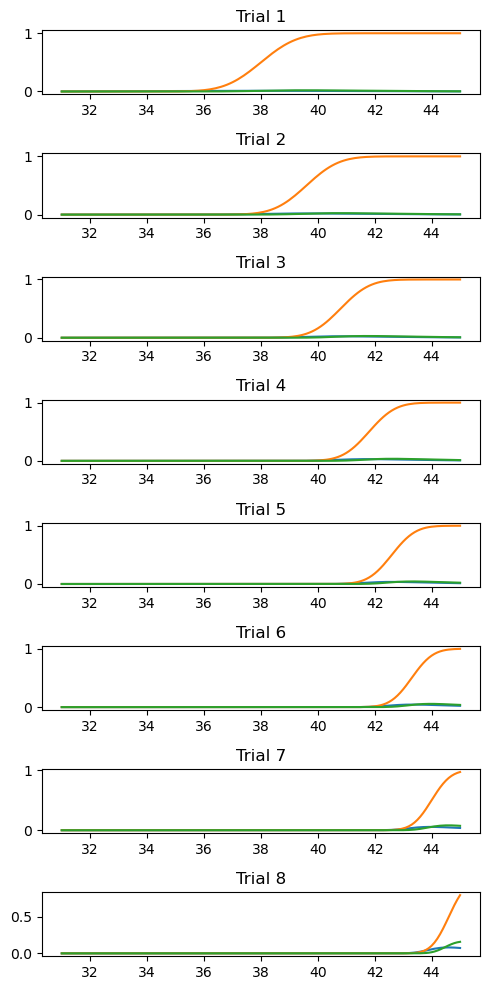

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Step 1: Define a prior probability distribution for the heat pain threshold
min_temperature = 31
max_temperature = 45
mean_temperature = (min_temperature + max_temperature) / 2
std_temperature = 3.5
likelihood_std_temperature = 1

x = np.arange(min_temperature, max_temperature+0.1, 0.1) # temperature range
prior = stats.norm.pdf(x, loc=mean_temperature, scale=std_temperature)
prior /= np.sum(prior)  # normalize to make it a valid probability distribution

# Step 2: Start the experiment with a predetermined temperature
current_temperature = np.round(x[np.argmax(prior)],2)

# Step 3-6: Repeat for each trial

# Store distributions and temperatures for each trial
priors = []
likelihoods = []
posteriors = []
temperatures = [current_temperature]

trials = 8

for trial in range(trials):  # example number of trials
    # Collect the subject's response
    response = input(f'Is {current_temperature} degrees Celsius painful? (y/n) ')

    # Define a likelihood function based on the response
    if response == 'y':
        likelihood = 1 - stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)
    else:
        likelihood = stats.norm.cdf(x, loc=current_temperature, scale=likelihood_std_temperature)
    likelihood_std_temperature *= 0.9 # decrease the standard deviation of the likelihood function

    # Update the prior distribution with the likelihood function to get a posterior distribution
    posterior = likelihood * prior
    posterior /= np.sum(posterior)  # normalize
    
    # Choose the temperature for the next trial based on the posterior distribution
    current_temperature = np.round(x[np.argmax(posterior)],2)

    # Store the distributions and temperature
    priors.append(prior)
    likelihoods.append(likelihood)
    posteriors.append(posterior)
    temperatures.append(current_temperature)
    
    # Update the prior for the next iteration
    prior = posterior


print(temperatures, "\n", np.diff(temperatures))


In [12]:
import ipywidgets as widgets
from IPython.display import display

def plot_trial(trial):
    # Clear the current figure
    plt.clf()

    # Plot the prior, likelihood, and posterior distributions for the selected trial
    plt.plot(x, priors[trial], label='Prior')
    plt.plot(x, likelihoods[trial], label='Likelihood')
    plt.plot(x, posteriors[trial], label='Posterior')
    plt.title(f'Trial {trial+1}')
    plt.legend()

# Create a slider for the trial number
trial_slider = widgets.IntSlider(min=0, max=trials-1, step=1, value=0)

# Use the interact function to automatically update the plot when the slider is moved
widgets.interact(plot_trial, trial=trial_slider)

interactive(children=(IntSlider(value=0, description='trial', max=7), Output()), _dom_classes=('widget-interac…

<function __main__.plot_trial(trial)>

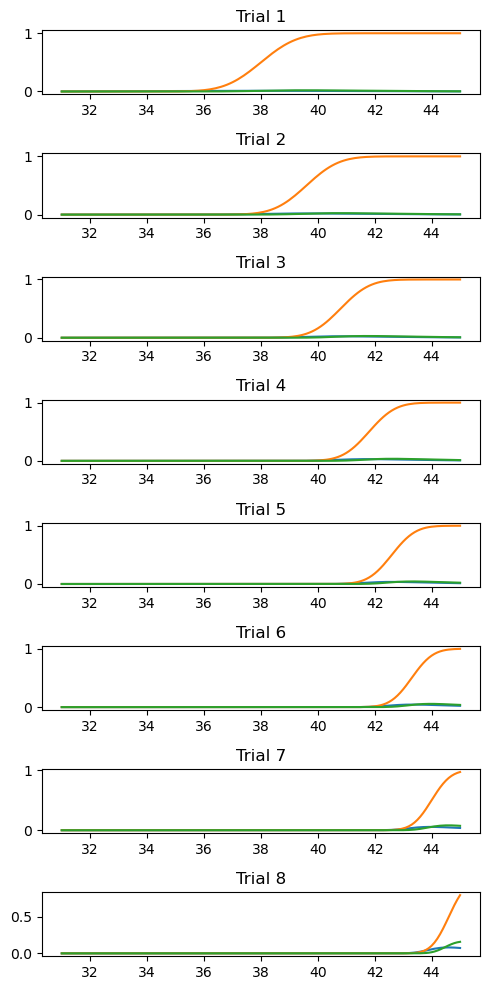

In [21]:
# old code
fig, ax = plt.subplots(trials, 1, figsize=(5, 10))
for trial in range(trials):
    # Plot the prior, likelihood, and posterior distributions
    ax[trial].plot(x, priors[trial], label='Prior')
    ax[trial].plot(x, likelihoods[trial], label='Likelihood')
    ax[trial].plot(x, posteriors[trial], label='Posterior')
    ax[trial].set_title(f'Trial {trial+1}')
plt.tight_layout()
plt.show()

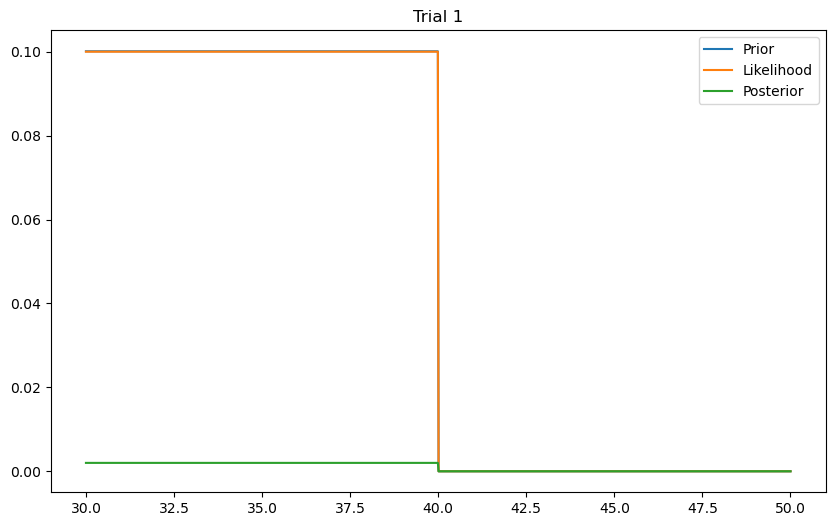

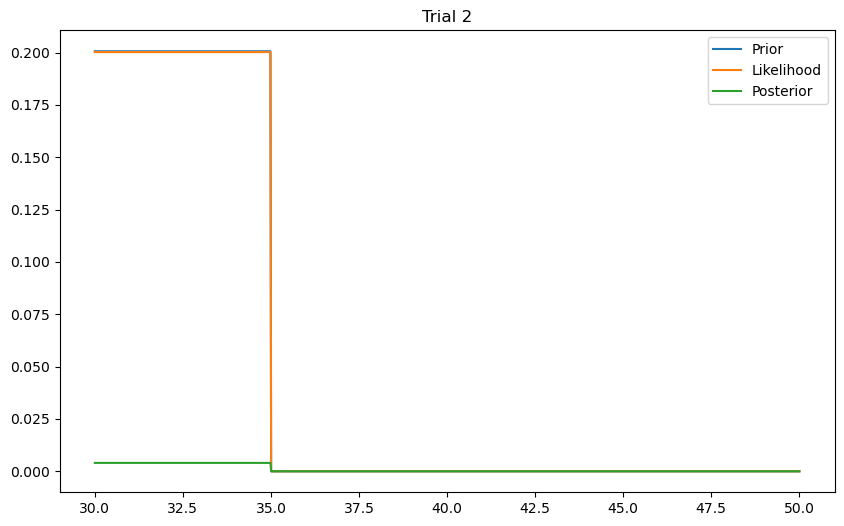

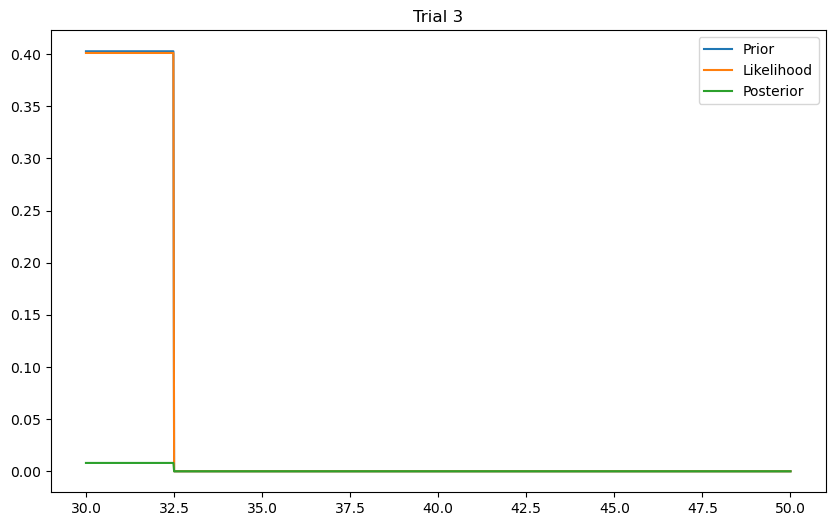

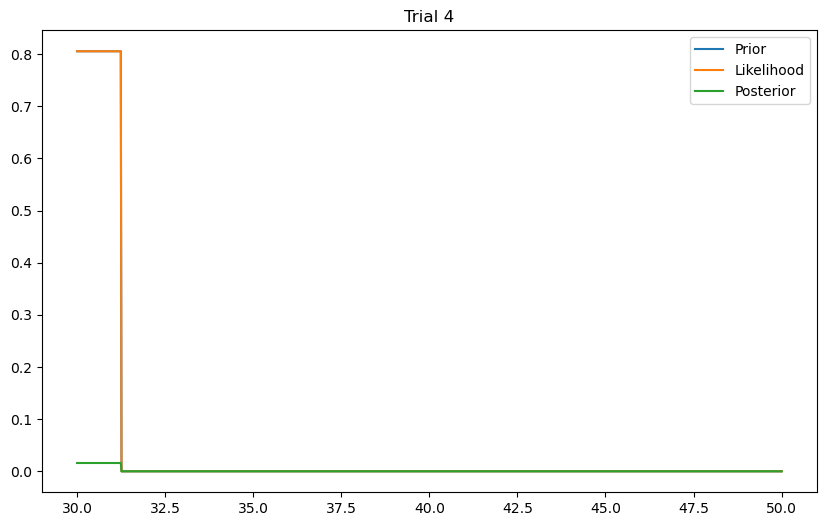

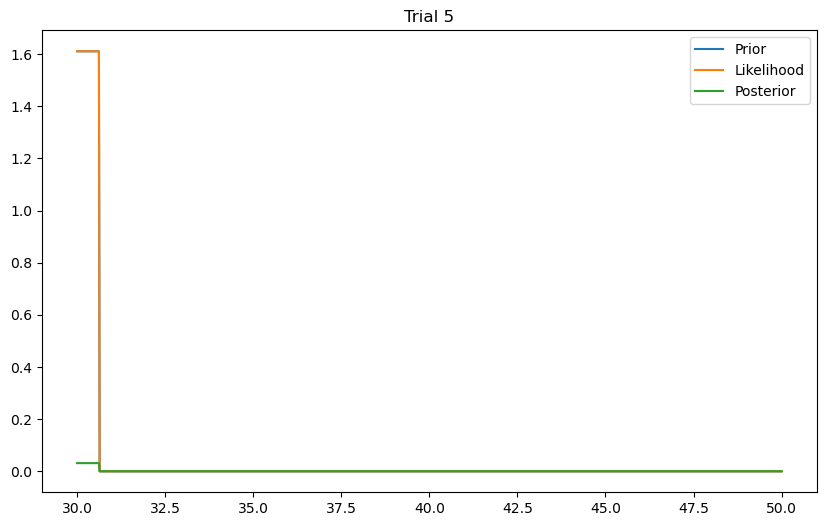

In [4]:
# with uniform distributions

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Step 1: Define a prior probability distribution for the heat pain threshold
min_temperature = 30
max_temperature = 50
prior = stats.uniform(min_temperature, max_temperature - min_temperature)

# Step 2: Start the experiment with a random or predetermined temperature
current_temperature = prior.mean()

# Step 3-6: Repeat for each trial
temperatures = []
for trial in range(5):  # example number of trials
    # Collect the subject's response
    response = input(f'Is {current_temperature} degrees Celsius painful? (yes/no) ')
    
    # Define a likelihood function based on the response
    if response == 'yes':
        likelihood = stats.uniform(current_temperature, max_temperature - current_temperature)
    else:
        likelihood = stats.uniform(min_temperature, current_temperature - min_temperature)
    
    # Update the prior distribution with the likelihood function to get a posterior distribution
    x = np.linspace(min_temperature, max_temperature, 1000)
    posterior = likelihood.pdf(x) * prior.pdf(x)
    posterior /= np.sum(posterior)  # normalize to make it a valid probability distribution
    
    # Update the prior for the next iteration
    min_temperature_posterior = x[np.where(posterior == max(posterior))][0]
    max_temperature_posterior = x[np.where(posterior > 0)][-1]
    prior = stats.uniform(min_temperature_posterior, max_temperature_posterior - min_temperature_posterior)
    
    # Choose the temperature for the next trial based on the posterior distribution
    current_temperature = prior.mean()

    # Plot the prior, likelihood, and posterior distributions
    plt.figure(figsize=(10, 6))
    plt.plot(x, prior.pdf(x), label='Prior')
    plt.plot(x, likelihood.pdf(x), label='Likelihood')
    plt.plot(x, posterior, label='Posterior')
    plt.title(f'Trial {trial+1}')
    plt.legend()
    plt.show()

    temperatures.append(current_temperature)
